# Libraries

In [86]:
import numpy as np
import pandas as pd 
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.0, style="dark")
import warnings 
from sklearn.svm import SVC, NuSVC
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy import stats
from scipy.stats import uniform, randint
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
# from tflearn.data_utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import interp
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from tensorflow.keras.utils import to_categorical

# Data Manipulation

In [87]:
## Make 1 or True  if you run colab
## Other wise 0 or False
##if you run in  colab

colab = 0
if colab ==True:
  data_dir='/content/drive/MyDrive/PIMA Journal/diabetes.csv'
  from google.colab import drive
  drive.mount('/content/drive')
else:
  
  data_dir='Diabetes_processed.csv'


In [88]:
data = pd.read_csv(data_dir)
all_clf_res = {
               'BloodPressure':[],
               'Glucose':[]
}

In [89]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,171.474227,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,113.606695,26.6,0.351,31.0,0
2,8.0,183.0,64.0,32.059259,171.474227,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,5.0,116.0,74.0,27.094512,113.606695,25.6,0.201,30.0,0


In [90]:
def swap_col(target_):
  swap_data = copy.deepcopy(data)
  swap_data[target_] = data.Outcome
  swap_data.Outcome = data[target_]
  swap_data.rename(columns = {'Outcome':target_, target_: 'Diabetic'}, inplace = True)
  #swap_data.Diabetic.replace({1:'Yes', 0:'No'} , inplace = True)
  return swap_data

In [91]:
data_BP = swap_col('BloodPressure')

#data_ST = swap_col('SkinThickness')
#data_Ins = swap_col('Insulin')
#data_BMI = swap_col('BMI')
#data_DPF = swap_col('DiabetesPedigreeFunction')
#data_Age = swap_col('Age')
#data_Pregnancies = swap_col('Pregnancies')

In [92]:
data_BP.head()

,Pregnancies,Glucose,Diabetic,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BloodPressure
0,6.0,148.0,1,35.000000,171.474227,33.6,0.627,50.0,72.0
1,1.0,85.0,0,29.000000,113.606695,26.6,0.351,31.0,66.0
2,8.0,183.0,1,32.059259,171.474227,23.3,0.672,32.0,64.0
3,1.0,89.0,0,23.000000,94.000000,28.1,0.167,21.0,66.0
4,5.0,116.0,0,27.094512,113.606695,25.6,0.201,30.0,74.0


In [93]:
knn_res = pd.DataFrame()
random_initializer=100            #random initializer
n_dots=50

# Utility Functions


In [94]:
def metrics (y_true, y_pred, probas_, tprs, mean_fpr):
  '''
  Parameters :
  Input - 
  y_true - true  value of input data    
  y_pred- predicted  value of input data  
  probas_- probability/confidence of predicted output

  return -True Negative(tn),False Positive(fp),False Negative(fn)
  True positive(tp),AUC(roc_auc),False Positive Rate(fpr),
  True positive rate(tpr)

  '''


  points=n_dots*'-'
  print(points)
#    print("Best parameters set found on development set:")
#    print(clf.best_params_)
  #fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
  #tprs.append(interp(mean_fpr, fpr, tpr))
  #tprs[-1][0] = 0.0
  #roc_auc = auc(fpr, tpr)
  #  aucs.append(roc_auc)
  print("Detailed classification report for current fold:")
  print()
  print(classification_report(y_true, y_pred))
  print()
  #print("Area Under ROC (AUC): {}".format(roc_auc))
  print()
  print('Confusion Matrix for current fold: ')
  print(confusion_matrix(y_true, y_pred))
  print()
  print("Accuracy for Current Fold: {}".format(accuracy_score(y_true, y_pred)))
  print()
  confusion_array = multilabel_confusion_matrix(y_true, y_pred)
  confusion_d = pd.DataFrame(confusion_array.reshape(-1, 4), columns=["TN", "FP", "FN", "TP"])
  tn, fp, fn, tp = np.array(confusion_d.TN), np.array(confusion_d.FP), np.array(confusion_d.FN), np.array(confusion_d.TP)

  return  tn, fp, fn, tp

#*******************************************************************************#

def plot_Current_ROC(fpr,tpr,iterator,roc_auc):
  
  '''
  Parameters :
  Input - 
  fpr - False positive rate
  tpr - True positive rate
  roc_auc -auc values of roc curve

  Output - 
  Visalization of current roc curve

  '''
  plt.plot(fpr,
          
          tpr,
          # Color[iterator],
          alpha=0.35,
          # label='macro-average ROC (AUC = {0:0.3f})'.format(roc_auc)
          # +FOLD[iterator],
          linewidth=1)
  

#*******************************************************************************#
   
def average_ROC(mean_fpr,tprs,aucs,TP,TN,FP,FN):

  '''
  Parameters :
  mean_fpr - Mean False positive rate
  tprs -values of true positive rate
  aucs  - values of auc
  TP    - True positive 
  TN    - True Negative
  FP    - False Positiv
  FN    - False Negative

  Output - 
  Visalization of TPR vs FPR plot
  '''
  sen = (np.sum(TP))/(np.sum(TP)+np.sum(FN))
  spe = (np.sum(TN))/(np.sum(TN)+np.sum(FP))

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  # mean_auc = auc(mean_fpr, mean_tpr)
  mean_auc = np.mean(aucs)
  std_auc = np.std(aucs)
  # plt.figure(figsize=(8, 5))
  # plt.grid(True)
  ax = plt.axes()
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)
  # Setting the background color
  ax.set_facecolor("white")
  
  ax.spines['bottom'].set_color('#000000')
  ax.spines['top'].set_color('#000000') 
  ax.spines['right'].set_color('#000000')
  ax.spines['left'].set_color('#000000')

  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Avg. ROC (AUC (avg $\pm$ std) = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
          lw=2, alpha=.8)
  
  plt.scatter((1-spe), sen, s=80, c='r', marker='x',)
  plt.scatter(0, sen, s=80, c='r', marker='x',)
  plt.scatter((1-spe),0, s=80, c='r', marker='x',)
  plt.axhline(y=sen, color='r', linestyle='--')
  plt.axvline(x=(1-spe), color='r', linestyle='--')
  plt.text((1-spe), 0.02, "FPR={:0.3f}".format((1-spe)))
  plt.text(0.009, sen+0.05, "TPR={:0.3f}".format(sen))

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='darkgray', alpha=0.5,
                  label=r'$\pm$ 1 Standard deviation')

  plt.xticks(np.arange(0.0, 1.01, step=0.1))
  plt.yticks(np.arange(0.0, 1.01, step=0.1))
  left=0.0
  right=1.0
  plt.xlim(left, right)
  plt.ylim(left, right)
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")
  # plt.grid(True)
  plt.show()

#*******************************************************************************#

def average_performance(Accuracy,TP,TN,FP,FN, target_col): 

  '''
  Parameters :
  Input - 
  Accuracy - value of accuracy
  TP  - True Positive
  TN  - True Negative
  FP  - False Positive
  FN  - False Negative


  Output - 
  It prints the average accuarcy,confusion matrix
  '''

  print()
  n_dotsav=(n_dots-len('Average'))//2
    
  print('-'*n_dotsav+'Average'+'-'*n_dotsav)
  #print("AUC (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(aucs),np.std(aucs)))
  print("Accuracy (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(Accuracy),np.std(Accuracy)))
  cm = [[int(np.mean(TP)), int(np.mean(FP))],[int(np.mean(FN)), int(np.mean(TN))]]
  print ('Avg. CM is '+str(cm))
  cm = [[int(np.sum(TP)), int(np.sum(FP))],[int(np.sum(FN)), int(np.sum(TN))]]
  print ('Total for all folds CM is '+str(cm))
  #re_auc=str(round(np.mean(aucs), 3))+'+/-'+str(round(np.std(aucs),3))
  re_accuracy=str(round(np.mean(Accuracy), 3))+'+/-'+str(round(np.std(Accuracy),3))
  all_clf_res[target_col].append(re_accuracy)

def creat_Model (classifier, X_Train, Y_Train, tuned_parameters, verbose):
 
    clf = GridSearchCV(classifier,
                    tuned_parameters,
                    verbose=verbose,
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1)
    clf.fit(X_Train, Y_Train)
    return clf

#*******************************************************************************#
    
def feature_Selector(data, algo, n_feature):
 
    if algo=='PCA':                                                   #for pca algorithm
        X_Data= data.iloc[:,:8].values
        pca = PCA(n_components=n_feature)                             #number of feature
        X_Data = pca.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
 
    if algo == 'ICA':
        X_Data= data.iloc[:,:8].values
        ICA = FastICA(n_components=n_feature, random_state=12) 
        X_Data = ICA.fit_transform(X_Data)
        return X_Data , data.iloc[:,8:].values
    
    if algo =='corr':                                                   #for ica algorithm
        if n_feature ==4:
            data = data[['F2','F5','F4','F6','Outcome']]                #for 4 feature
            return data.iloc[:,:4].values, data.iloc[:,4:].values
        if n_feature ==6:
            data = data[['F1','F2','F4','F5','F6','F8','Outcome']]       #for 6 feature
            return data.iloc[:,:6].values, data.iloc[:,6:].values
        
    if algo == 'None':
        return data.iloc[:,:8].values, data.iloc[:,8:].values            #if feature selection is off all features are counted

#*******************************************************************************#

In [95]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=random_initializer)

# **Classifiers**

## KNN Classifier

In [96]:
def clf_KNN(X_Data, Y_Lavel, target_col):

    Accuracy = []                                                                # for store the value of accuracy 
    FP = []                                                                      # for store False Positive 
    TN = []                                                                      # for True Negative
    FN = []                                                                      # for False Negative
    TP = []                                                                      # for True Positive
    tprs = []                                                                    # for true positive rates
    aucs_kNN = []                                                                # for store the values of auc
    iterator=0
    mean_fpr = np.linspace(0, 1, 100)
    fig = plt.figure(figsize=(8, 5))

    for train_index, test_index in kf.split(X_Data,Y_Lavel):                     # split in train and test
        #   print("TRAIN:", train_index, "TEST:", test_index)
        X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
        Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test data and label

        ###########################################
        # define the hyper parameters of Knn
        n_neighbors = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49]
        leaf_size = [5,10,15,20,25,30,35,40,45,50]
        Distance = [1,2]
        ############################################


        tuned_parameters = [ {'n_neighbors': n_neighbors,                         #define parameters with different algorithm
                            'algorithm' : ['brute'],
                            'p':Distance},

                            {'n_neighbors': n_neighbors, 
                            'algorithm' : ['ball_tree'],
                            'leaf_size' : leaf_size,
                            'p':Distance},

                            {'n_neighbors': n_neighbors, 
                            'algorithm' : ['kd_tree'],
                            'leaf_size' : leaf_size,
                            'p':Distance}]

        clf = creat_Model (classifier = KNeighborsClassifier(),                     #create the model 
                          X_Train = X_Train,
                          Y_Train = Y_Train,
                          tuned_parameters = tuned_parameters,
                          verbose=0)

        tn, fp, fn, tp = metrics (y_true = Y_Test,               #get the values of  model evaluation 
                                          y_pred = clf.predict(X_Test),
                                          probas_ = clf.predict_proba(X_Test), 
                                          tprs = tprs,
                                          mean_fpr = mean_fpr)
        #tprs.append(interp(mean_fpr, fpr, tpr))                                     
        #tprs[-1][0] = 0.0
        #aucs_kNN.append(roc_auc)
        #plot_Current_ROC (fpr,tpr,iterator,roc_auc)                                 #plot the roc of current fold
        iterator += 1
        plot_confusion_matrix(clf, X_Test, Y_Test)
        TN.append(tn)
        FP.append(fp)
        FN.append(fn)
        TP.append(tp)
        Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
    #average_ROC(mean_fpr,tprs,aucs_kNN,TP,TN,FP,FN)                                 #plot average roc curve
    average_performance(Accuracy,TP,TN,FP,FN, target_col)                  #print the average performance of the model   

## Decision Tree

In [97]:
def clf_DT(X_Data, Y_Lavel, target_col):

  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_Tree = []                                                               # for store the values of auc of tree model
  iterator=0
  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))

  for train_index, test_index in kf.split(X_Data,Y_Lavel):
      #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]

                                                                              # define the decision tree parameters 

      tuned_parameters = {'criterion': ['gini','entropy'],
                        'splitter': ['best'],
                        'min_samples_split':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                        'min_samples_leaf': [1,2,3,4,5] }

      clf = creat_Model (classifier = DecisionTreeClassifier( random_state=random_initializer),
                        X_Train = X_Train,                                    # create the model using DecisionTree Classifier 
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)

      tn, fp, fn, tp  = metrics (y_true = Y_Test,           #get the evaluation parameters of model
                                y_pred = clf.predict(X_Test),
                                probas_ = clf.predict_proba(X_Test),
                                tprs = tprs, 
                                mean_fpr = mean_fpr)
      #tprs.append(interp(mean_fpr, fpr, tpr))
      #tprs[-1][0] = 0.0
      #aucs_Tree.append(roc_auc)                                                # plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  #average_ROC(mean_fpr,tprs,aucs_Tree,TP,TN,FP,FN)                             #plot average roc curve
  average_performance(Accuracy,TP,TN,FP,FN, target_col)                          #print the average performance of the model

## Random Forest

In [98]:
def clf_RF(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_Forest = []                                                             # for store the values of auc of Random Forest model
  iterator=0
  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))

  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     #split dataset into train /test
  #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                # data and label of train dataset
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              # data and label of test dataset

      # parameters of Random Forest model
      tuned_parameters = {'criterion': ['gini','entropy']}

      clf = creat_Model (classifier = RandomForestClassifier( random_state=random_initializer),
                        X_Train = X_Train,                                      # create a model using random forest classifier
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)

      tn, fp, fn, tp = metrics (y_true = Y_Test,              #evaluation parameters of random forest model
                                y_pred = clf.predict(X_Test),
                                probas_ = clf.predict_proba(X_Test),
                                tprs = tprs, 
                                mean_fpr = mean_fpr)
      
      #tprs.append(interp(mean_fpr, fpr, tpr))
      #tprs[-1][0] = 0.0
      #aucs_Forest.append(roc_auc)
      #plot_Current_ROC (fpr,tpr,iterator,roc_auc)                               #plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  #average_ROC(mean_fpr,tprs,aucs_Forest,TP,TN,FP,FN)                            #plot average roc curve
  average_performance(Accuracy,TP,TN,FP,FN, target_col)                         #print the average performance of the model

## AdaBoost

In [99]:
def clf_AB(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_aBoost = []                                                             # for store the values of auc of Adaboost model
  iterator=0

  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))


  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     #split into train and test 
      #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #data and label

      #####################################################
      # define the parameters of adaboost algorithm
      #####################################################
      tuned_parameters = { 'algorithm': ['SAMME','SAMME.R'],
                        'learning_rate':[0.1,0.5,1.0],
                        'n_estimators': [10,50,100,200]}

      
      clf = creat_Model (classifier = AdaBoostClassifier( random_state=random_initializer),
                        X_Train = X_Train,                                      # create a model using  AdaBoost Classifier
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      tn, fp, fn, tp = metrics (y_true = Y_Test,             # model evaluation parametrs
                                y_pred = clf.predict(X_Test),
                                probas_ = clf.predict_proba(X_Test),
                                tprs = tprs, 
                                mean_fpr = mean_fpr)
      #tprs.append(interp(mean_fpr, fpr, tpr))
      #tprs[-1][0] = 0.0
      #aucs_aBoost.append(roc_auc)
      #plot_Current_ROC (fpr,tpr,iterator,roc_auc)                              #plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  #average_ROC(mean_fpr,tprs,aucs_aBoost,TP,TN,FP,FN)                           #plot average roc curve
  average_performance(Accuracy,TP,TN,FP,FN, target_col)                        #print the average performance of the model

## Naive Bayes

In [100]:
def clf_NB(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_NB = []                                                                 # for store the values of auc of  model
  iterator=0

  mean_fpr = np.linspace(0, 1, 100) 
  fig = plt.figure(figsize=(8, 5))


  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     #split into train and test
  #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test  data and label


      #############################################
      # define parameters of Naive Bayes model 
      ############################################
      var_smoothing = [1e-01,
                      1e-02,
                      1e-03,
                      1e-04,
                      1e-05,
                      1e-06,
                      1e-07,
                      1e-08,
                      1e-09,
                      1e-10,
                      1e-11,
                      1e-12]

      tuned_parameters = [{'var_smoothing': var_smoothing}]

      #############################################################
      clf = creat_Model (classifier = GaussianNB(),                             # create model using Naive Bias
                        X_Train = X_Train,
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      tn, fp, fn, tp = metrics (y_true = Y_Test,             # model evaluation parameters
                                y_pred = clf.predict(X_Test),
                                probas_ = clf.predict_proba(X_Test),
                                tprs = tprs, 
                                mean_fpr = mean_fpr)
      #tprs.append(interp(mean_fpr, fpr, tpr))
      #tprs[-1][0] = 0.0
      #aucs_NB.append(roc_auc)
      #plot_Current_ROC (fpr,tpr,iterator,roc_auc)                               #plot the roc of current fold
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
  #average_ROC(mean_fpr,tprs,aucs_NB,TP,TN,FP,FN)                               #plot average roc curve
  average_performance(Accuracy,TP,TN,FP,FN, target_col)                            #print the average performance of the model

## XGBoost

In [101]:
def clf_XGB(X_Data, Y_Lavel, target_col):
  Accuracy = []                                                                # for store the value of accuracy 
  FP = []                                                                      # for store False Positive 
  TN = []                                                                      # for True Negative
  FN = []                                                                      # for False Negative
  TP = []                                                                      # for True Positive
  tprs = []                                                                    # for true positive rates
  aucs_xboost = []                                                                # for store the values of auc
  sn = []                                                                      # for sensitivity 
  sp = []                                                                      # for specificity
  pr = []                                                                      # for precision
  FOR = []                                                                     # for False omission rate 
  DOR = []                                                                     # for Diagnostic odds ratio (DOR)
  iterator=0
  mean_fpr = np.linspace(0, 1, 100)
  fig = plt.figure(figsize=(8, 5))


  for train_index, test_index in kf.split(X_Data,Y_Lavel):                     # split into train and test
  #   print("TRAIN:", train_index, "TEST:", test_index)
      X_Train, X_Test = X_Data[train_index], X_Data[test_index]                #train data and label
      Y_Train, Y_Test = Y_Lavel[train_index], Y_Lavel[test_index]              #test data and label

      #####################################
      ## define the parameters 
      ######################################
      tuned_parameters = {
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.5, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
          }

      clf = creat_Model (classifier = xgb.XGBClassifier(objective = "multi:softprob", eval_metric = 'merror', random_state=random_initializer),
                        X_Train = X_Train,                                        # create model using XGB classifier 
                        Y_Train = Y_Train,
                        tuned_parameters = tuned_parameters,
                        verbose=0)
      tn, fp, fn, tp  = metrics (y_true = Y_Test,               #evaluate the model parameters
                        y_pred = clf.predict(X_Test),
                        probas_ = clf.predict_proba(X_Test),
                        tprs = tprs, 
                        mean_fpr = mean_fpr)
      #tprs.append(interp(mean_fpr, fpr, tpr))
      #tprs[-1][0] = 0.0
      #aucs_xboost.append(roc_auc)
      #plot_Current_ROC(fpr,tpr,iterator,roc_auc)                                  #plot the roc of current fold 
      iterator += 1
      TN.append(tn)
      FP.append(fp)
      FN.append(fn)
      TP.append(tp)
      Accuracy.append(accuracy_score(Y_Test, clf.predict(X_Test)))
      sn.append(tp/(tp+fn))
      sp.append(tn/(fp+tn))
      pr.append(tp/(tp+fp))
      FOR.append(fn/(tn+fn))
      DOR.append((tp*tn)/(fp*fn))

  #average_ROC(mean_fpr,tprs,aucs_xboost,TP,TN,FP,FN)                              #plot average roc curve
  average_performance(Accuracy,TP,TN,FP,FN, target_col)               #print the average performance of the model

  #####################################################################
  #    print the sensitivity,specificity,precision,for,dor of model
  #####################################################################
  print("Sensitivity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sn),np.std(sn)))
  print("Specificity (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(sp),np.std(sp)))
  print("Precision (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(pr),np.std(pr)))
  print("FOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(FOR),np.std(FOR)))
  print("DOR (Avg. +/- Std.) is  %0.3f +/- %0.3f" %(np.mean(DOR),np.std(DOR)))

# With BloodPressure as Target

In [102]:
data_BP.head(), data_BP.shape

(   Pregnancies  Glucose  ...   Age  BloodPressure
 0          6.0    148.0  ...  50.0           72.0
 1          1.0     85.0  ...  31.0           66.0
 2          8.0    183.0  ...  32.0           64.0
 3          1.0     89.0  ...  21.0           66.0
 4          5.0    116.0  ...  30.0           74.0
 
 [5 rows x 9 columns], (636, 9))

In [103]:
def categorize_BP(data_BP):
    
    BP = "BloodPressure"
    try:
        low_i = data_BP.loc[(data_BP[BP] <= 60)] #diastolic less than 80 is normal
        normal_i = data_BP.loc[(data_BP[BP] > 60) & (data_BP[BP] < 80)] #diastolic between 60 and 80 is normal
        high_i =  data_BP.loc[data_BP[BP] >= 80] #diastolic greater than 80 is high
 
        data_BP[BP][low_i.index] = 0
        data_BP[BP][normal_i.index] = 1
        data_BP[BP][high_i.index] = 2
     
    except:
        pass
    
    return data_BP

In [104]:
data_BP = categorize_BP(data_BP)

In [105]:
data_BP.BloodPressure.value_counts()

1.0    362
2.0    167
0.0    107
Name: BloodPressure, dtype: int64

In [106]:
data_BP.columns = ['F' + str(i) for i in range(1,9)]+['Outcome'] #Renaming

In [107]:
X_Data,Y_Lavel = feature_Selector(data_BP, algo='None', n_feature=8)  

In [108]:
np.unique(Y_Lavel,return_counts = True)

(array([0., 1., 2.]), array([107, 362, 167]))

#### Analyzing **KNN**

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      0.99      0.72        73
         2.0       0.00      0.00      0.00        34

    accuracy                           0.56       128
   macro avg       0.19      0.33      0.24       128
weighted avg       0.32      0.56      0.41       128



Confusion Matrix for current fold: 
[[ 0 21  0]
 [ 0 72  1]
 [ 0 34  0]]

Accuracy for Current Fold: 0.5625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.58      1.00      0.74        73
         2.0       0.50      0.03      0.06        33

    accuracy                           0.58       127
   macro avg       0.36      0.34 

<Figure size 576x360 with 0 Axes>

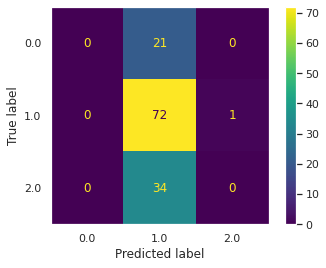

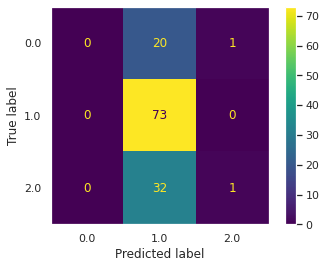

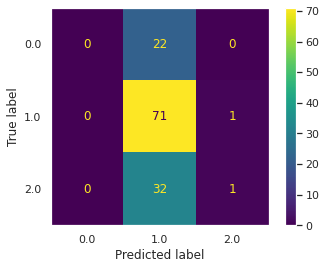

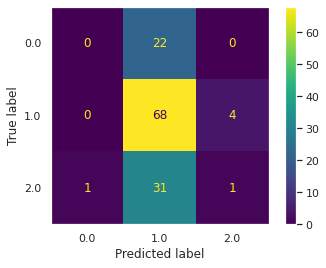

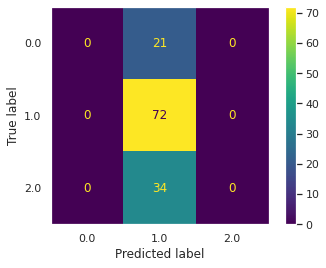

In [109]:
clf_KNN(X_Data, Y_Lavel, 'BloodPressure')

#### Analyzing **Decision Trees**

In [110]:
clf_DT(X_Data, Y_Lavel, 'BloodPressure')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      1.00      0.73        73
         2.0       0.00      0.00      0.00        34

    accuracy                           0.57       128
   macro avg       0.19      0.33      0.24       128
weighted avg       0.33      0.57      0.41       128



Confusion Matrix for current fold: 
[[ 0 21  0]
 [ 0 73  0]
 [ 0 34  0]]

Accuracy for Current Fold: 0.5703125

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      1.00      0.73        73
         2.0       0.00      0.00      0.00        33

    accuracy                           0.57       127
   macro avg       0.19      0.

<Figure size 576x360 with 0 Axes>

#### Analyzing **Random Forest**

In [111]:
clf_RF(X_Data, Y_Lavel, 'BloodPressure')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.60      0.14      0.23        21
         1.0       0.58      0.90      0.71        73
         2.0       0.50      0.15      0.23        34

    accuracy                           0.58       128
   macro avg       0.56      0.40      0.39       128
weighted avg       0.56      0.58      0.50       128



Confusion Matrix for current fold: 
[[ 3 18  0]
 [ 2 66  5]
 [ 0 29  5]]

Accuracy for Current Fold: 0.578125

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.17      0.05      0.07        21
         1.0       0.58      0.82      0.68        73
         2.0       0.44      0.24      0.31        33

    accuracy                           0.54       127
   macro avg       0.40      0.3

<Figure size 576x360 with 0 Axes>

#### Analyzing **AdaBoost**

In [112]:
clf_AB(X_Data, Y_Lavel, 'BloodPressure')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      1.00      0.73        73
         2.0       0.00      0.00      0.00        33

    accuracy                           0.57       127
   macro avg       0.19      0.33      0.24       127
weighted avg       0.33      0.57      0.42       127



Confusion Matrix for current fold: 
[[ 0 21  0]
 [ 0 73  0]
 [ 0 33  0]]

Accuracy for Current Fold: 0.5748031496062992

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.57      0.89      0.70        72
         2.0       0.47      0.21      0.29        33

    accuracy                           0.56       127
   macro avg       0.3

<Figure size 576x360 with 0 Axes>

#### Analyzing **Naive Bayes**

In [113]:
clf_NB(X_Data, Y_Lavel, 'BloodPressure')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      0.96      0.71        73
         2.0       0.40      0.06      0.10        34

    accuracy                           0.56       128
   macro avg       0.32      0.34      0.27       128
weighted avg       0.43      0.56      0.43       128



Confusion Matrix for current fold: 
[[ 0 21  0]
 [ 0 70  3]
 [ 0 32  2]]

Accuracy for Current Fold: 0.5625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      1.00      0.73        73
         2.0       0.00      0.00      0.00        33

    accuracy                           0.57       127
   macro avg       0.19      0.33 

<Figure size 576x360 with 0 Axes>

#### Analyzing **XGBoost**

In [114]:
clf_XGB(X_Data, Y_Lavel, 'BloodPressure')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      0.96      0.72        73
         2.0       0.50      0.09      0.15        34

    accuracy                           0.57       128
   macro avg       0.36      0.35      0.29       128
weighted avg       0.46      0.57      0.45       128



Confusion Matrix for current fold: 
[[ 0 21  0]
 [ 0 70  3]
 [ 0 31  3]]

Accuracy for Current Fold: 0.5703125

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.57      1.00      0.73        73
         2.0       0.00      0.00      0.00        33

    accuracy                           0.57       127
   macro avg       0.19      0.

<Figure size 576x360 with 0 Axes>

# With Glucose as Target

In [115]:
def categorize_GL(data_GL):
    #Oral glucose tolerance test
    GL = "Glucose"
    try:
        low_i = data_GL.loc[(data_GL[GL] <= 70)] # low
        normal_i = data_GL.loc[(data_GL[GL] > 70) & (data_GL[GL] < 125)] #prediabetic
        high_i =  data_GL.loc[data_GL[GL] >= 125] #high

        data_GL[GL][low_i.index] = 0
        data_GL[GL][normal_i.index] = 1
        data_GL[GL][high_i.index] = 2
     
    except:
        pass
    
    return data_GL

In [116]:
data_GL = swap_col('Glucose')
print(data_GL.head()), data_GL.shape

   Pregnancies  Diabetic  ...   Age  Glucose
0          6.0         1  ...  50.0    148.0
1          1.0         0  ...  31.0     85.0
2          8.0         1  ...  32.0    183.0
3          1.0         0  ...  21.0     89.0
4          5.0         0  ...  30.0    116.0

[5 rows x 9 columns]


(None, (636, 9))

In [117]:
data_GL = categorize_GL(data_GL)

In [118]:
data_GL.Glucose.value_counts()

1.0    394
2.0    232
0.0     10
Name: Glucose, dtype: int64

In [119]:
data_GL.columns = ['F' + str(i) for i in range(1,9)]+['Outcome'] #Renaming

In [120]:
X_Data,Y_Lavel = feature_Selector(data_GL, algo='None', n_feature=8)  

#### Analyzing **KNN**

In [ ]:
clf_KNN(X_Data, Y_Lavel, 'Glucose')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.68      0.87      0.76        79
         2.0       0.62      0.34      0.44        47

    accuracy                           0.66       128
   macro avg       0.43      0.40      0.40       128
weighted avg       0.64      0.66      0.63       128



Confusion Matrix for current fold: 
[[ 0  2  0]
 [ 0 69 10]
 [ 0 31 16]]

Accuracy for Current Fold: 0.6640625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.71      0.77      0.74        78
         2.0       0.57      0.51      0.54        47

    accuracy                           0.66       127
   macro avg       0.43      0.

In [ ]:
#clf_KNN(X_Data, Y_Lavel, 'Glucose')

In [ ]:
all_clf_res['BloodPressure']

#### Analyzing **Decision Trees**

In [ ]:
clf_DT(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **Random Forest**

In [ ]:
clf_RF(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **AdaBoost**

In [ ]:
clf_AB(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **Naive Bayes**

In [ ]:
clf_NB(X_Data, Y_Lavel, 'Glucose')

#### Analyzing **XGBoost**

In [128]:
clf_XGB(X_Data, Y_Lavel, 'Glucose')

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.68      0.82      0.75        79
         2.0       0.58      0.40      0.48        47

    accuracy                           0.66       128
   macro avg       0.42      0.41      0.41       128
weighted avg       0.63      0.66      0.64       128



Confusion Matrix for current fold: 
[[ 0  2  0]
 [ 0 65 14]
 [ 0 28 19]]

Accuracy for Current Fold: 0.65625

--------------------------------------------------
Detailed classification report for current fold:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.78      0.86      0.82        78
         2.0       0.73      0.64      0.68        47

    accuracy                           0.76       127
   macro avg       0.50      0.50

<Figure size 576x360 with 0 Axes>

# Results

In [129]:
row_index = ['BloodPressure', 'Glucose']
model_names = ['KNN', 'DecisionTree', 'RandomForest', 'AdaBoost', 'NaiveBayes', 'XGBoost']
results = pd.DataFrame(all_clf_res['BloodPressure'], index = model_names)
results['Glucose'] = all_clf_res['Glucose']
results = results.transpose()

In [130]:
results.index = row_index

In [132]:
print("Multiclass")
results

Multiclass


,KNN,DecisionTree,RandomForest,AdaBoost,NaiveBayes,XGBoost
BloodPressure,0.564+/-0.013,0.569+/-0.003,0.544+/-0.03,0.569+/-0.01,0.546+/-0.03,0.553+/-0.02
Glucose,0.686+/-0.019,0.659+/-0.048,0.709+/-0.031,0.712+/-0.026,0.689+/-0.022,0.72+/-0.042
